# Using the Bayesian Approach to Analyze Functional Genomics Screen with Pymc

Gregor Mendel's foundational work in genetics paved the way for modern techniques like CRISPR and RNAi screens used to decipher gene functions at a molecular level. However, the 'large p, small n' problem in these techniques, where we have ample genetic data but limited sample sizes, presents a significant analytical challenge. Hence, this situation necessitates an elegant solution, which we aim to provide by utilizing Bayesian and causal inference, to identify upregulated genes from such data sets.

To address this, we'll follow Richard McElreath approach to data analysis known as "Fortune Telling Frameworks": Goal settings, Assumptions ,define Priors and prior prediction analysis, simulation and comparing models, Reporting and revisiting each step as new data emerges.
To initiate our data analysis, we acknowledge the inherent high dispersion in our dataset, attributed to biological variability and experimental conditions like high multiplicity of infection (MOI), which complicates the analysis by introducing a collider effect.

## Data simulation and EDA

To simulate CRISPR screen dynamics, we implemented a two-phase process in a Python-based probabilistic programming framework. Phase 1 initiates with infecting cells with specific sgRNAs, modeling the $H_{t_0}$ sample (sgRNA read counts before screening) as drawn from a multinomial distribution, influenced by initial plasmid read counts ($m$) following a negative binomial distribution. The formula:
\begin{align*}
f(H_{t_0}) = \frac{\binom{r}{H_{t_0}}\binom{N-r}{n-H_{t_0}}}{\binom{N}{n}},
\end{align*}
accounts for infection efficiency and prior sgRNA abundance, where $r$ is the total successful sgRNA incorporations, $n$ the total cells, and $N$ the virus particles.

Phase 2 focuses on the post-screening scenario ($H_{t_1}$ sample), marking true positive sgRNAs that target key genes for the study. This phase simulates the selection of sgRNAs impacting gene fitness by introducing stochasticity through a binomial distribution to mimic the randomness of biological systems and optical screening processes. The structured approach ensures accurate emulation of CRISPR screening's selection mechanism by:
1. Marking sgRNAs targeting hit genes.
2. Simulating optical screen selection with binomial noise.
3. Selecting cells exhibiting desired phenotypes to evaluate sgRNA efficacy.



Start with simulate data:

In [ ]:
dftall = df.dfTall
dftall

,Gene,sgRNA,class,readCount,logRcount,tag
0,ABHD6,ABHD6_+_58223718.23-P1P2,Ht0,30,3.465736,0
1,ABHD6,ABHD6_+_58223966.23-P1P2,Ht0,1,1.098612,0
2,ABHD6,ABHD6_-_58223553.23-P1P2,Ht0,19,3.044522,0
3,ABHD6,ABHD6_-_58223594.23-P1P2,Ht0,7,2.197225,0
4,ABHD6,ABHD6_-_58223914.23-P1P2,Ht0,9,2.397895,0
...,...,...,...,...,...,...
12982,ZNF692,ZNF692_+_249153208.23-P1P2,M,45,3.850148,2
12983,ZNF692,ZNF692_+_249153252.23-P1P2,M,16,2.890372,2
12984,ZNF692,ZNF692_-_249153060.23-P1P2,M,14,2.772589,2
12985,ZNF692,ZNF692_-_249153259.23-P1P2,M,15,2.833213,2


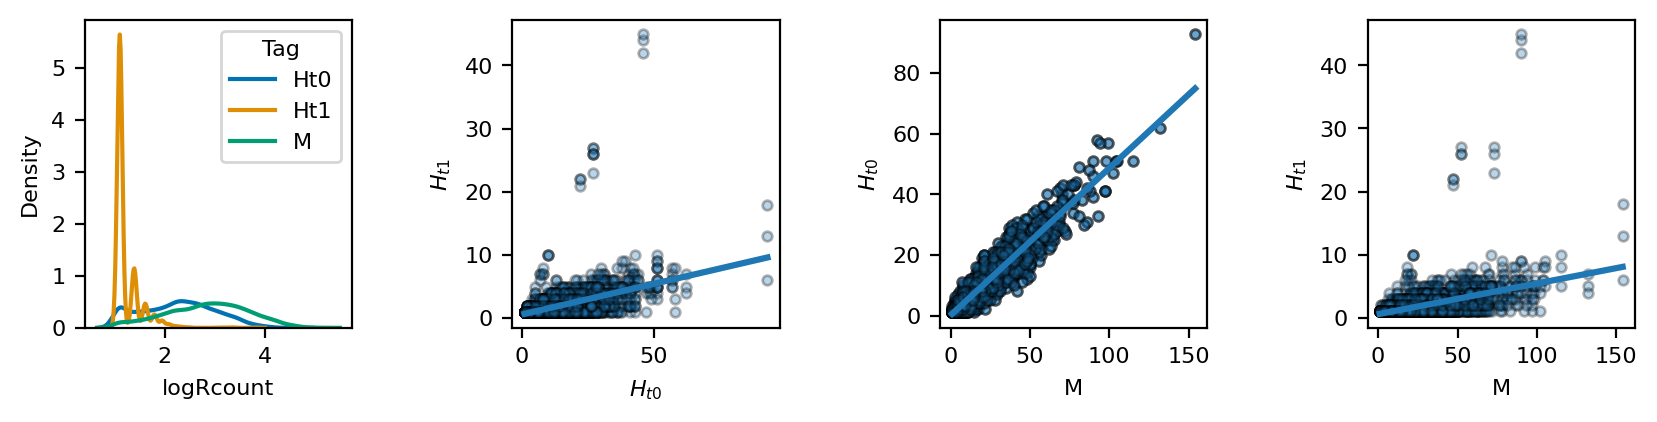

In [ ]:
plt.rcParams['font.size'] = 8
palette1 = sns.color_palette("colorblind",9)
selcolor = [palette1[i] for i in [0, 1, 2]]
tags = dftall['class'].unique()
color_dict = dict(zip(tags, selcolor))

fig, axes = plt.subplots(1, 4,figsize=(10, 2))
axes = axes.ravel()
for tag in tags:
    sns.kdeplot(dftall[dftall['class'] == tag]['logRcount'], ax=axes[0], color=color_dict[tag], label=tag)
axes[0].legend(title='Tag')

sns.regplot(x=dftall.loc[dftall["tag"]==0,"readCount"].values, y=dftall.loc[dftall["tag"]==1,"readCount"].values, scatter_kws={'s': 12,'edgecolors': 'black','alpha':0.3}, ci = None, ax= axes[1])
axes[1].set_xlabel(r"$H_{t0}$")
axes[1].set_ylabel(r"$H_{t1}$")
sns.regplot(x=dftall.loc[dftall["tag"]==2,"readCount"].values, y=dftall.loc[dftall["tag"]==0,"readCount"].values, scatter_kws={'s': 12,'edgecolors': 'black','alpha':0.3}, ci = None, ax= axes[2])
axes[2].set_xlabel(r"M")
axes[2].set_ylabel(r"$H_{t0}$")
sns.regplot(x=dftall.loc[dftall["tag"]==2,"readCount"].values, y=dftall.loc[dftall["tag"]==1,"readCount"].values, scatter_kws={'s': 12,'edgecolors': 'black','alpha':0.3}, ci = None, ax= axes[3])
axes[3].set_xlabel(r"M")
axes[3].set_ylabel(r"$H_{t1}$")
plt.subplots_adjust(wspace = 0.6)


We assume that our data inherently exhibit high dispersion across both features (sgRNAs) and samples. This dispersion is not random but reflects the complex biological variability and experimental conditions. Recognizing this allows us to anticipate the need for analytical methods that can accommodate such variability. One source of dipersion is revolves around the implications of high multiplicity of infection (MOI). High MOI, where cells end up expressing more than one sgRNA, is often employed intentionally to ensure broad coverage across the genome. The presence of multiple sgRNAs within a single cell complicates our ability to pinpoint which sgRNA is responsible for any observed changes in cellular fitness. This complexity necessitates a nuanced approach to data analysis, where the potential for overrepresentation of certain sgRNAs due to high MOI is acknowledged and addressed. The introduction of high MOI inadvertently creates a collider effect. This statistical phenomenon occurs when the relationship between two variables (in this case, sgRNA and cellular fitness) is influenced by a third variable (MOI). The collider effect can obscure the true impact of specific sgRNAs on cellular fitness, leading to potential misinterpretations of the data. To effectively 'open' this collider and mitigate its confounding influence, we incorporate data on the abundance of sgRNAs prior to infection, we provide a baseline against which post-treatment changes can be more accurately assessed. Furthermore, adjusting for sgRNA fitness, based on previous CRISPR screen data, allows us to account for variability in sgRNA efficiency. These adjustments are crucial for refining our understanding of sgRNA's role in cellular fitness, enabling a more accurate interpretation of the data that accounts for the collider effect introduced by high MOI.


https://towardsdatascience.com/a-step-by-step-guide-in-detecting-causal-relationships-using-bayesian-structure-learning-in-python-c20c6b31cee5

In [ ]:
!pip install -U bnlearn

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


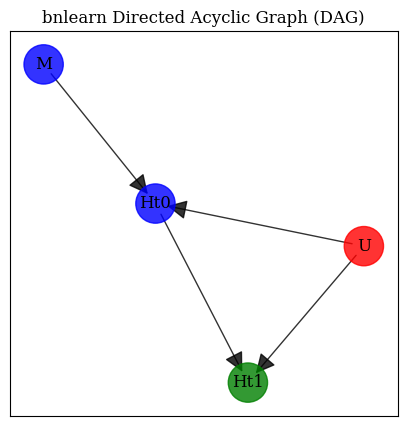

In [ ]:
plt.rcParams["font.family"] = "serif"
import bnlearn as bn
df = pd.DataFrame({"M", "Ht0", "Ht1", "U"})
edges = [("Ht0", "Ht1"),
         ('M', 'Ht0'),
         ('U', 'Ht0'),
         ('U', 'Ht1')]
DAG = bn.make_DAG(edges)
node_properties = bn.get_node_properties(DAG)
node_properties['U']['node_color']='#FF0000'
node_properties['M']['node_color']='#0000FF'
node_properties['Ht0']['node_color']='#0000FF'
node_properties['Ht1']['node_color']='#008000'
_ = bn.plot(DAG, node_properties=node_properties, interactive=False,params_static = {'width':5, 'height':5, 'font_size':12, 'font_family':'serif', 'alpha':0.8, 'node_shape':'o', 'facecolor':'white', 'font_color':'#000000'})

## Define Priors and prior prediction analysis

We propose a Generalized Linear Model (GLM) to analyze the expected sgRNA read count distribution post-treatment, denoted as $\mu_{t1}$. This model assumes that the post-treatment read count ($\mu_{t1}$) is influenced by a factor of $\beta$ times the read count before treatment ($H_{t0}$). The estimated distributions of read counts before ($H_{t0}^{\prime}$) and after treatment ($H_{t1}^{\prime}$) vary according to a multivariate normal distribution, with the expected intercept $\mu_{t0}$ and the estimated effect $\theta$ for sgRNA abundance before infection, denoted as $M$ (for master plasmid).

The mathematical formulation is as follows:

\begin{align*}
H_{t0}, H_{t1} &\sim \text{MvNormal}\left(\begin{bmatrix} \mu_{mj}\\ \mu_{xj} \end{bmatrix}, \Sigma\right) \\
\mu_{mj} &\sim \alpha_j + \theta_j \times \text{M}\\
\mu_{xj} &\sim \beta_{j} \times H_{t0}\\
\Sigma &\sim \text{LKJ}(n, \eta, \nu)\\
\nu &\sim \text{HalfNormal}(10)
\end{align*}

In this model, $\Sigma$ is distributed according to an LKJ distribution with parameters $n$, $\eta$, and $\nu$, where $\nu$ follows a Half-Normal distribution with a standard deviation of 10. This GLM framework allows us to estimate the impact of sgRNA abundance prior to infection and the fitness exposure variable on the read count distribution, providing a nuanced understanding of sgRNA's role in cellular fitness post-treatment.
Prior to assigning priors, we conducted some exploratory data analysis to better understand the distribution and relationships within the data.

--------

We want to figure out what values $\beta$ could take. To do this, we’re going to look at how much our post-treatment read count ($\mu_{t1}$) gets enriched.

We'll create two different scenarios and then compare them. We're interested in how much effect unrelated reads might have when there's a high level of infection, compared to when it's low.

By doing this, we hope to get a better sense of what our prior values might be. It's a bit like detective work; we're piecing together clues to solve the mystery of $\beta$.

In [ ]:
df_high = runSimulation(targetNum = 5, geneNum = 300, effectSgRNA = 2,getData = True, mu = 20, a = 1.2,low = 1, high = 10,size = 10_000,FalseLimits = (0.05,0.25),ObservationNum = (20,3))
df_low = runSimulation(targetNum = 5, geneNum = 300, effectSgRNA = 2,getData = True, mu = 20, a = 1.2,low = 1, high = 3,size = 10_000,FalseLimits = (0.05,0.25),ObservationNum = (20,3))

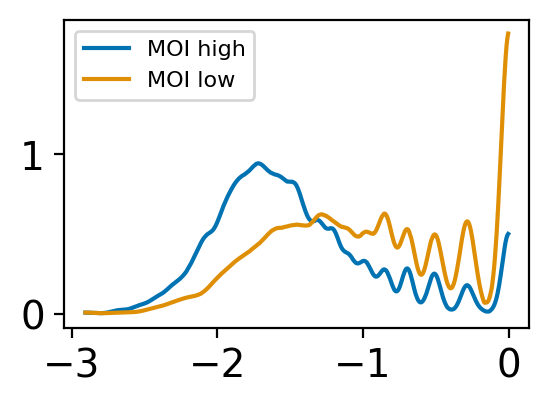

In [ ]:
def betaCalc(df,label):
  return df.loc[df["tag"]==label,"logRcount"].values - df.loc[df["tag"]==0,"logRcount"].values
fig, axes = plt.subplots(1, 1,figsize=(3, 2))
axes.locator_params(axis='x', nbins=5)
_ = az.plot_kde(betaCalc(df_high.dfTall,label = 1),plot_kwargs={"label":'MOI high',"color":selcolor[0]})
_ = az.plot_kde(betaCalc(df_low.dfTall,label = 1),plot_kwargs={"label":'MOI low',"color":selcolor[1]})

To gather additional insights, we sourced data from [BioGrid ORCS]('https://orcs.thebiogrid.org/').

<ipython-input-26-88a747e5b3a0>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('https://raw.githubusercontent.com/gkanfer/AIPySdeAnalyzer/main/Prior_distribution.png')


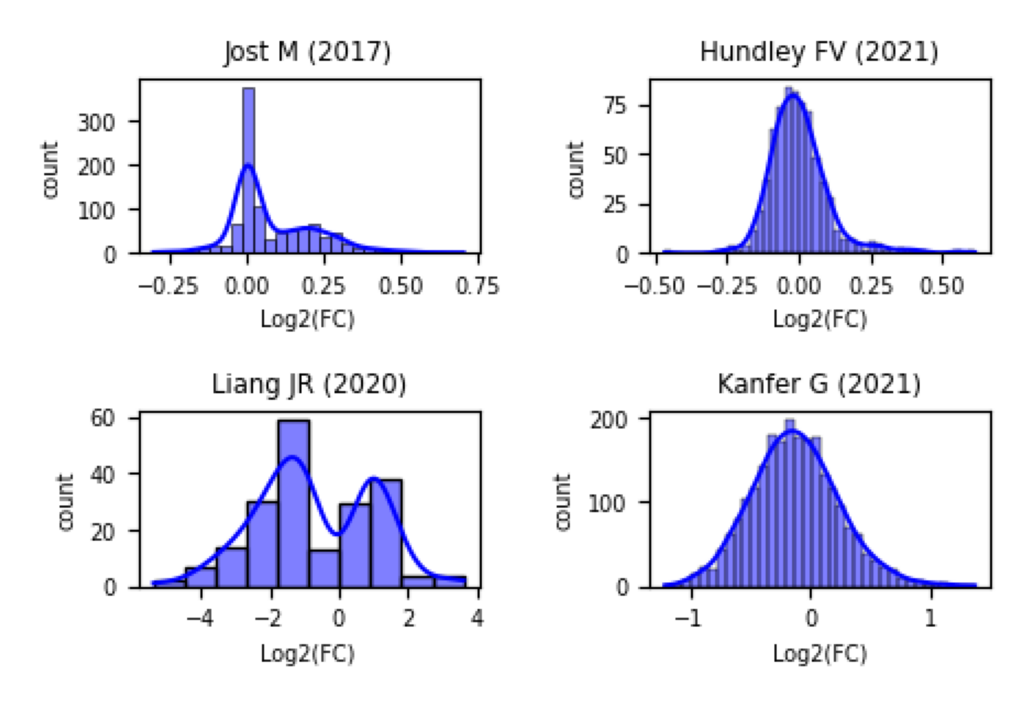

In [ ]:
import imageio
# Read the image file
img = imageio.imread('https://raw.githubusercontent.com/gkanfer/AIPySdeAnalyzer/main/Prior_distribution.png')
# Display the image
_ = plt.imshow(img)
plt.axis('off')  # remove axis
plt.show()

This platform offers access to previously conducted CRISPR screens with similar setups. I've collated data from four databases and observed that the range of enrichment fold change (denoted here as $\beta$) falls between -4 and 4, in the least informative case. Let's move forward with modelling based on these revised assumptions.

In [ ]:
dftall.columns

Index(['Gene', 'sgRNA', 'class', 'readCount', 'logRcount', 'tag'], dtype='object')

In [ ]:
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
# setting up data
dftall_h0 = dftall.loc[dftall["tag"]==0,:]
dftall_h1 = dftall.loc[dftall["tag"]==1,:]
dftall_M = dftall.loc[dftall["tag"]==2,:]

sgRNA, mn_sgRNA = dftall_h0.sgRNA.factorize()
Genes, mn_Genes = dftall_h0.Gene.factorize()
h0 = dftall_h0.logRcount.values
h1 = dftall_h1.logRcount.values
M = dftall_M.logRcount.values
xy = np.ones((len(h0),2))
xy[:,0] = h0
xy[:,1] = h1
coords = {"sgRNA": mn_sgRNA,"Genes": mn_Genes}
# model prior prediction
with pm.Model(coords=coords) as model_ppa:
  theta = pm.Normal("theta_bar",0, 4, dims=("sgRNA"))
  beta = pm.Normal("z_beta", 0, 4 , dims=("sgRNA"))

  chol, _, _ = pm.LKJCholeskyCov(
      "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(10.0), compute_corr=True
  )

  Mu_Y = pm.Deterministic("Mu_Y",(beta[sgRNA])+h0)
  Mu_X = pm.Deterministic("Mu_X",(1+theta[sgRNA])+M)
  XY_obs = pm.Data("XY_obs", xy, mutable=True)
  sgRNA_ = pm.Data("sgRNA", sgRNA)

  counts = pm.MvNormal("counts", mu=pt.stack([Mu_X, Mu_Y]).T, chol=chol, observed=XY_obs)
  prior_pred = pm.sample_prior_predictive(samples=50, random_seed=rng)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


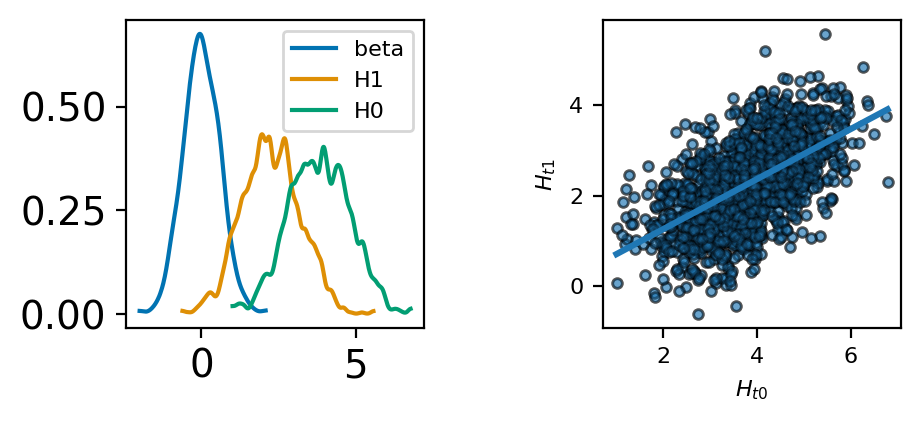

In [ ]:
fig, axes = plt.subplots(1, 2,figsize=(5, 2))
axes = axes.ravel()
_ = az.plot_kde(prior_pred.prior.z_beta.mean(dim = ["chain","draw"]).values,plot_kwargs={"label":'beta',"color":selcolor[0]},ax = axes[0])
_ = az.plot_kde(prior_pred.prior.Mu_Y.mean(dim = ["chain","draw"]).values,plot_kwargs={"label":'H1',"color":selcolor[1]},ax = axes[0])
_ = az.plot_kde(prior_pred.prior.Mu_X.mean(dim = ["chain","draw"]).values,plot_kwargs={"label":'H0',"color":selcolor[2]},ax = axes[0])
sns.regplot(x=prior_pred.prior.Mu_X.mean(dim = ["chain","draw"]).values, y=prior_pred.prior.Mu_Y.mean(dim = ["chain","draw"]).values, scatter_kws={'s': 12,'edgecolors': 'black','alpha':0.3}, ci = None, ax= axes[1])
axes[1].set_xlabel(r"$H_{t0}$")
axes[1].set_ylabel(r"$H_{t1}$")
plt.subplots_adjust(wspace = 0.6)

It appears that the weakly informative result yielded a reasonable output. The beta parameter is centered around zero and hasn't changed significantly. Now, it's the perfect time to set our model into motion. So, let's run it!

In [ ]:
import jax
with pm.Model(coords=coords) as model_ppa:
  theta = pm.Normal("theta_bar",0, 4, dims=("sgRNA"))
  beta = pm.Normal("z_beta", 0, 4 , dims=("sgRNA"))

  chol, _, _ = pm.LKJCholeskyCov(
      "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(10.0), compute_corr=True
  )

  Mu_Y = pm.Deterministic("Mu_Y",(beta[sgRNA])+h0)
  Mu_X = pm.Deterministic("Mu_X",(1+theta[sgRNA])+M)
  XY_obs = pm.Data("XY_obs", xy, mutable=True)
  sgRNA_ = pm.Data("sgRNA", sgRNA)

  counts = pm.MvNormal("counts", mu=pt.stack([Mu_X, Mu_Y]).T, chol=chol, observed=XY_obs)
  trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=RANDOM_SEED)